# Tracking speed - MLtraq vs MLflow

In this experiment, we evaluate the tracking performance of MLFlow and MLtraq varying:

* Number of experiments tracked
* Number of runs tracked
* Number of values tracked

Results averaged on `10` runs.

In [ ]:
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull

import mlflow
import mltraq


@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

In [ ]:
# MLflow and MLtraq versions
print("mlflow", mlflow.__version__)
print("mltraq", mltraq.__version__)

In [ ]:
def test_mlflow(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLflow tracking with a specified number of experiments, runs and values.
    """
    mlflow.set_tracking_uri("sqlite:///:memory:")
    # MLflow does not recreate the SQLite db in memory if we set it again with
    # set_tracking_uri . However, since the runs are executed in separate processes,
    # every process triggers the recreation of the database.
    for _ in range(n_experiments):
        experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
        for _ in range(n_runs):
            with mlflow.start_run(experiment_id=experiment_id):
                for _ in range(0, n_values):
                    mlflow.log_metric(key="value", value=123)
            mlflow.end_run()

In [ ]:
def test_mltraq(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLtraq tracking with a specified number of experiments, runs and values.
    """
    session = mltraq.create_session()
    for _ in range(n_experiments):
        experiment = session.create_experiment()
        for _ in range(n_runs):
            with experiment.run() as run:
                run.fields.value = []
                for _ in range(0, n_values):
                    run.fields.value.append(123)
        experiment.persist()

In [ ]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Warm up with creation of DB for MLflow, that
        # given it uses Alembic to maintain the schema,
        # it might be significantly slower.
        test_mlflow(n_experiments=1, n_runs=1, n_values=1)

        log.append(tag="begin")
        if run.params.method == "MLflow":
            test_mlflow(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "MLtraq":
            test_mltraq(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields |= run.params


e = mltraq.create_experiment()
e.add_runs(
    method=["MLflow", "MLtraq"],
    i=range(10),
    n_experiments=[1, 10, 20],
    n_runs=[1, 10, 20],
    n_values=[1, 10, 20],
)
e.execute(eval_time)

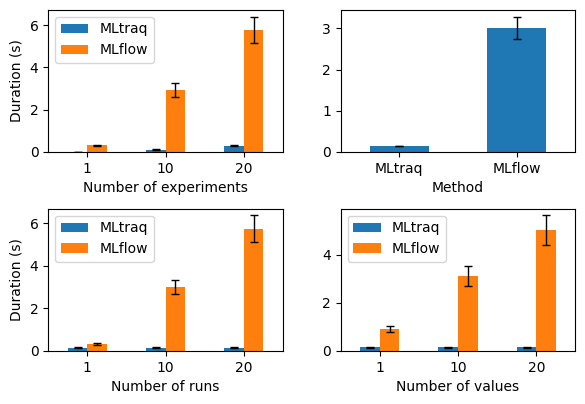

In [6]:
import matplotlib.pyplot as plt
from mltraq.utils.plot import bar_plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[6, 4], nrows=2, ncols=2)
fig.tight_layout()
plt.subplots_adjust(hspace=0.4)

bar_plot(
    e.runs.df(),
    x="n_experiments",
    x_label="Number of experiments",
    y="duration",
    group="method",
    yerr=True,
    ax=ax1,
    y_label="Duration (s)",
    y_lim={"bottom": 0},
    y_grid=False,
)

bar_plot(
    e.runs.df(),
    x="method",
    x_label="Method",
    y="duration",
    yerr=True,
    ax=ax2,
    y_lim={"bottom": 0},
)
ax2.yaxis.label.set_visible(False)

bar_plot(
    e.runs.df(),
    x="n_runs",
    x_label="Number of runs",
    y="duration",
    yerr=True,
    y_label="Duration (s)",
    group="method",
    ax=ax3,
    y_lim={"bottom": 0},
)

bar_plot(
    e.runs.df(),
    x="n_values",
    x_label="Number of values",
    y="duration",
    yerr=True,
    group="method",
    ax=ax4,
    y_label="duration (s)",
    y_lim={"bottom": 0},
)
ax4.yaxis.label.set_visible(False)